# Unsupervised Anomaly Detection using Vector Embeddings from Pre-trained <U>doc2vec model</U>
This is a continuation of the prior research. In this notebook, we are leveraging the <u>Isolation Forest</u> algorithm to perform unsupervised training of an anomaly detection model, using text <u>vector embeddings</u> as the input. in this working example, we will build a doc2vec model using sample mixed benign/malicious logs and use that to calculate vector embeddings for the logs we wish to analyze for anomalies.

In [11]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas 
#! pip install matplotlib
#! pip install scikit-learn
#! pip install gensim
#! pip install nltk
#import nltk
#nltk.download('punkt_tab')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec

In [2]:
# Load pre-trained doc2vec model
model_dbow = Doc2Vec.load('doc2vec_wikipedia_dbow.model')
#model_dbow = Doc2Vec.load('doc2vec_wikipedia_dbow_fine-tuned-on-dns.model')

model_dm = Doc2Vec.load('doc2vec_wikipedia_dm.model')
#model_dm = Doc2Vec.load('doc2vec_wikipedia_dm_fine-tuned-on-dns.model')

In [3]:
# Do a test inference to see if the vector embedding looks like something we'd expect...so far, so good
new_doc = word_tokenize('GET http://www.example.com/ HTTP/1.1"" 200 140321 ""http://www.example.com/"" ""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15')
# Try both
print('sample vector DBOW: ', model_dbow.infer_vector(new_doc))
print('sample vector DM: ', model_dm.infer_vector(new_doc))


sample vector DBOW:  [-0.00967153 -0.01293611 -0.00784051  0.00877184  0.01221822  0.00263142
 -0.00068832  0.00639191 -0.00477371  0.00649528 -0.01244953  0.00678846
  0.00368534  0.00409783 -0.01098826 -0.00922909 -0.00233805  0.01316404
 -0.00561749 -0.01809672  0.00085552 -0.00201168  0.00266296  0.00532744
  0.00500726 -0.00958546  0.00149053  0.00487961 -0.014498   -0.01004729
  0.00812698  0.00985076  0.00373712 -0.01619013  0.00166297  0.00056895
  0.0047859  -0.00033136  0.00693001 -0.01085962 -0.00487785 -0.01004678
 -0.01003876 -0.00612072  0.01629311  0.00881733  0.00209588 -0.00863373
 -0.00555534  0.00499041 -0.006898   -0.00826554 -0.02828857 -0.0096571
  0.01013459  0.01037028 -0.00535267 -0.00084751 -0.00940639  0.00108088
 -0.00171514  0.00849377  0.00584579  0.00178959 -0.00250288  0.01656178
  0.01017388  0.01080547 -0.0108213   0.01278953  0.0013298   0.01097965
  0.00331419  0.01199062 -0.00686028 -0.00491898  0.01773759 -0.01756094
 -0.01407916 -0.00667624 -0.004

In [4]:
# We'll use the fabricated mixed proxy logs with known 950 benign log entries and 50 malicious log entries 
# Our goal is to see if we can get them accurately classified into that 950 benign + 50 malicious
# Read the log data into a dataframe, and drop the columns we don't need for this exercise, and 
# extract the return code to use in validating the eventual output
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df['return_code'] = df['Log Entry'].str.split().str[3]

df.sample(3)

,ID,Log Entry,return_code
25,26,"GET http://www.example.com/ HTTP/1.1"" 200 7670...",200
101,102,GET http://update.software.com/version.xml HTT...,200
208,209,"GET http://cloudstorage.com/login HTTP/1.1"" 20...",200


In [5]:
# Let's confirm that we have 950 benign (rc = 200) and 50 malicious (rc != 200)
df['return_code'].value_counts()

return_code
200    950
403     18
500     11
404     11
400     10
Name: count, dtype: int64

In [6]:
# We'll use the pre-trained doc2vec model to calculate vector embeddings for these logs

# Use a lambda function to encode the text in each row and apply it to a new column
df['embedding_dbow'] = df['Log Entry'].apply(lambda text: model_dbow.infer_vector(word_tokenize(text.lower())))
df['embedding_dm'] = df['Log Entry'].apply(lambda text: model_dm.infer_vector(word_tokenize(text.lower())))

df.sample(3)

,ID,Log Entry,return_code,embedding_dbow,embedding_dm
431,432,"GET http://www.example.com/ HTTP/1.1"" 200 2107...",200,"[-0.02266943, -0.020861972, -0.015400338, 0.00...","[-0.0018101194, -0.006817521, -0.002870513, 0...."
650,651,"GET http://cloudstorage.com/login HTTP/1.1"" 20...",200,"[-0.016649615, -0.018889062, -0.01567302, 0.00...","[0.002594163, -0.004114544, -0.0040216735, 0.0..."
64,65,GET http://intranet.company.com/docs/document....,200,"[-0.026088608, -0.038572695, -0.0226622, 0.002...","[0.0041654045, -0.013098864, -0.0017098042, 0...."


## Train Isolation Forest unsupervised model using the vector embeddings
We are doing semantic anomaly detection in this exercise.  The vector embeddings try to capture what the text content <i>means</i>, so applying isolation forest algorithm those numeric values will give us anomalies that <i>have a different meaning</i> than the norm.  The accuracy of this depends on how good the vector embeddings captured the meaning of the text content.

In [7]:
## DBOW
# Define a model object with the Isolation Forest algorithm
iforest_dbow_model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding_dbow'].values)

# Fit the data to the model
iforest_dbow_model.fit(X)

# Display parameter values that were used
iforest_dbow_model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [8]:
## DM
# Define a model object with the Isolation Forest algorithm
iforest_dm_model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding_dm'].values)

# Fit the data to the model
iforest_dm_model.fit(X)

# Display parameter values that were used
iforest_dm_model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [9]:
## DBOW
# Add a column to the DF for scores from the model's decision_function
df['raw_score_dbow'] = iforest_dbow_model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score_dbow'] = iforest_dbow_model.predict(X)

## DM
# Add a column to the DF for scores from the model's decision_function
df['raw_score_dm'] = iforest_dm_model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score_dm'] = iforest_dm_model.predict(X)


In [10]:
# Display the data with the columns added
df.sample(3)

,ID,Log Entry,return_code,embedding_dbow,embedding_dm,raw_score_dbow,anomaly_score_dbow,raw_score_dm,anomaly_score_dm
770,771,GET http://cloudstorage.com/authenticate HTTP/...,200,"[-0.026100459, -0.03905963, -0.021110617, 0.00...","[0.006498156, -0.014434209, -0.00040215947, 0....",-0.162693,-1,0.011609,1
501,502,"GET http://www.example.com/script.js HTTP/1.1""...",200,"[-0.021879971, -0.017887453, -0.017265636, 0.0...","[0.0018999776, -0.0046594385, -0.0020740211, 0...",-0.135533,-1,0.105159,1
902,903,GET http://cloudstorage.com/authenticate HTTP/...,200,"[-0.029608363, -0.034349527, -0.022268297, 0.0...","[0.0037025865, -0.012477041, -0.0008251908, 0....",-0.155312,-1,0.081620,1


In [11]:
# The outliers have anomaly_score = -1 
print("DBOW: ", df['anomaly_score_dbow'].value_counts())
print("DM: ", df['anomaly_score_dm'].value_counts())

DBOW:  anomaly_score_dbow
-1    1000
Name: count, dtype: int64
DM:  anomaly_score_dm
 1    974
-1     26
Name: count, dtype: int64


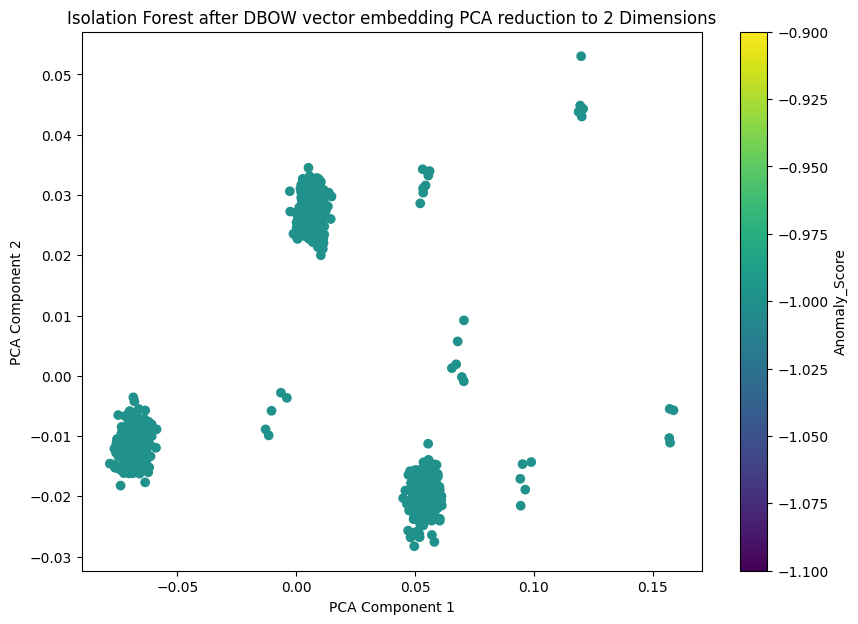

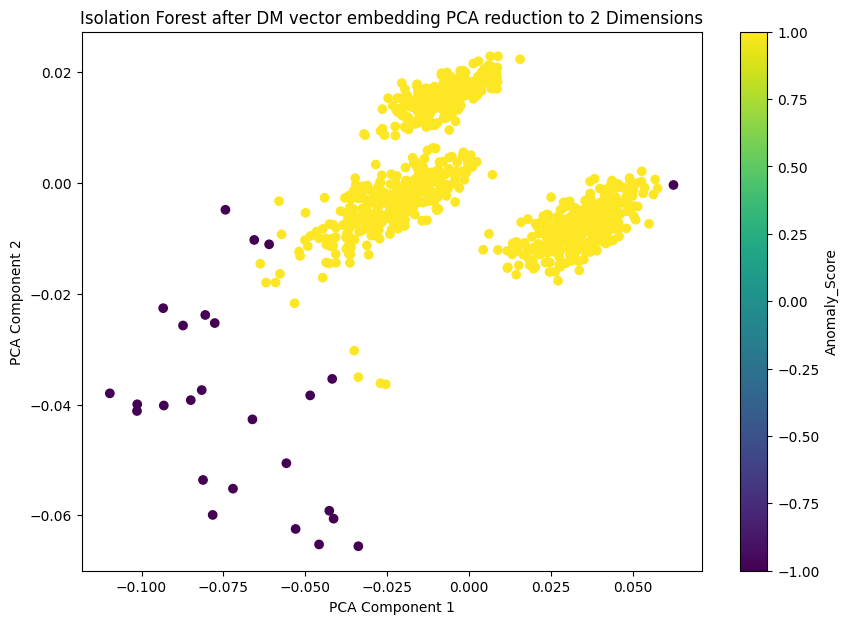

In [12]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

## DBOW
# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings_dbow = df['embedding_dbow'].tolist()
reduced_embeddings_dbow = pca.fit_transform(embeddings_dbow)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings_dbow[:, 0], reduced_embeddings_dbow[:, 1], c=df['anomaly_score_dbow'], cmap='viridis', marker='o')
plt.title('Isolation Forest after DBOW vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()

## DM
# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings_dm = df['embedding_dm'].tolist()
reduced_embeddings_dm = pca.fit_transform(embeddings_dm)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings_dm[:, 0], reduced_embeddings_dm[:, 1], c=df['anomaly_score_dm'], cmap='viridis', marker='o')
plt.title('Isolation Forest after DM vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()


# Judging from the plot, this appears to have done a decent job with the anomaly detection

In [14]:
# Let's examine whether the flagged anomalies include the 50 known malicious log entries
print("With DBOW embeddings:")
print("Valid positive: Count of entries flagged anomaly and return_code != 200: ", end='')
print(len(df[(df['anomaly_score_dbow'] == -1) & (df['return_code'] != '200')][['return_code', 'anomaly_score_dbow']]))
print("Valid negative: Count of entries not flagged anomaly and return_code = 200: ", end='')
print(len(df[(df['anomaly_score_dbow'] == 1) & (df['return_code'] == '200')][['return_code', 'anomaly_score_dbow']]))
print("FALSE POSITIVE: Count of entries flagged anomaly but return_code = 200: ", end='')
print(len(df[(df['anomaly_score_dbow'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score_dbow']]))
print("FALSE NEGATIVE: Count of entries NOT flagged anomaly and return_code != 200: ", end='')
print(len(df[(df['anomaly_score_dbow'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score_dbow']]))
print()
print("With DM embeddings:")
print("Valid positive: Count of entries flagged anomaly and return_code != 200: ", end='')
print(len(df[(df['anomaly_score_dm'] == -1) & (df['return_code'] != '200')][['return_code', 'anomaly_score_dm']]))
print("Valid negative: Count of entries not flagged anomaly and return_code = 200: ", end='')
print(len(df[(df['anomaly_score_dm'] == 1) & (df['return_code'] == '200')][['return_code', 'anomaly_score_dm']]))
print("FALSE POSITIVE: Count of entries flagged anomaly but return_code = 200: ", end='')
print(len(df[(df['anomaly_score_dm'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score_dm']]))
print("FALSE NEGATIVE: Count of entries not flagged anomaly and return_code != 200: ", end='')
print(len(df[(df['anomaly_score_dm'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score_dm']]))


With DBOW embeddings:
Valid positive: Count of entries flagged anomaly and return_code != 200: 50
Valid negative: Count of entries not flagged anomaly and return_code = 200: 0
FALSE POSITIVE: Count of entries flagged anomaly but return_code = 200: 950
FALSE NEGATIVE: Count of entries NOT flagged anomaly and return_code != 200: 0

With DM embeddings:
Valid positive: Count of entries flagged anomaly and return_code != 200: 25
Valid negative: Count of entries not flagged anomaly and return_code = 200: 949
FALSE POSITIVE: Count of entries flagged anomaly but return_code = 200: 1
FALSE NEGATIVE: Count of entries not flagged anomaly and return_code != 200: 25


In [ ]:
# REVISE
# Let's examine "false negatives"...rows not flagged as anomaly that have non-200 return code
#pd.set_option('max_colwidth', None) # show full width of cols
#df[(df['anomaly_score'] == 1) & (df['return_code'] != '200')][['return_code', 'anomaly_score', 'Log Entry']]


In [ ]:
# REVISE
# Let's examine the "false positives"...rows flagged as anomaly but have return_code 200
#pd.set_option('max_colwidth', None) # show full width of showing cols
#df[(df['anomaly_score'] == -1) & (df['return_code'] == '200')][['return_code', 'anomaly_score', 'Log Entry']]


Note:  Still a work in progress...